# Movie Recommendation System using KNN

This notebook implements a movie recommendation system using K-Nearest Neighbors (KNN) based on user ratings. The dataset includes movies and user ratings, and the system finds similar movies based on user preferences.

In this notebook, we will:
1. Load and explore the dataset.
2. Build a sparse matrix representation of the movie-user interactions.
3. Use KNN to recommend movies.
4. Visualize key data points.

---

In [5]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Seaborn and Matplotlib settings for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 5]


In [6]:
# Load the ratings and movies datasets
ratings = pd.read_csv(".\Rating.csv")
movies = pd.read_csv(".\movies.csv")

# Displaying the first few entries of the datasets for an initial view
print(ratings.head())
print(movies.head())


   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [7]:
genres = {}
for gen in movies['genres']:
    genr = set()
    genr.update(gen.split("|"))
    for i in genr:
        if i in genres:
            genres[i] += 1
        else:
            genres[i] = 1
genres.pop('(no genres listed)')
print(genres)


{'Adventure': 4145, 'Comedy': 16870, 'Children': 2935, 'Animation': 2929, 'Fantasy': 2731, 'Romance': 7719, 'Drama': 25606, 'Thriller': 8654, 'Crime': 5319, 'Action': 7348, 'Horror': 5989, 'Mystery': 2925, 'Sci-Fi': 3595, 'IMAX': 195, 'Documentary': 5605, 'War': 1874, 'Musical': 1054, 'Western': 1399, 'Film-Noir': 353}


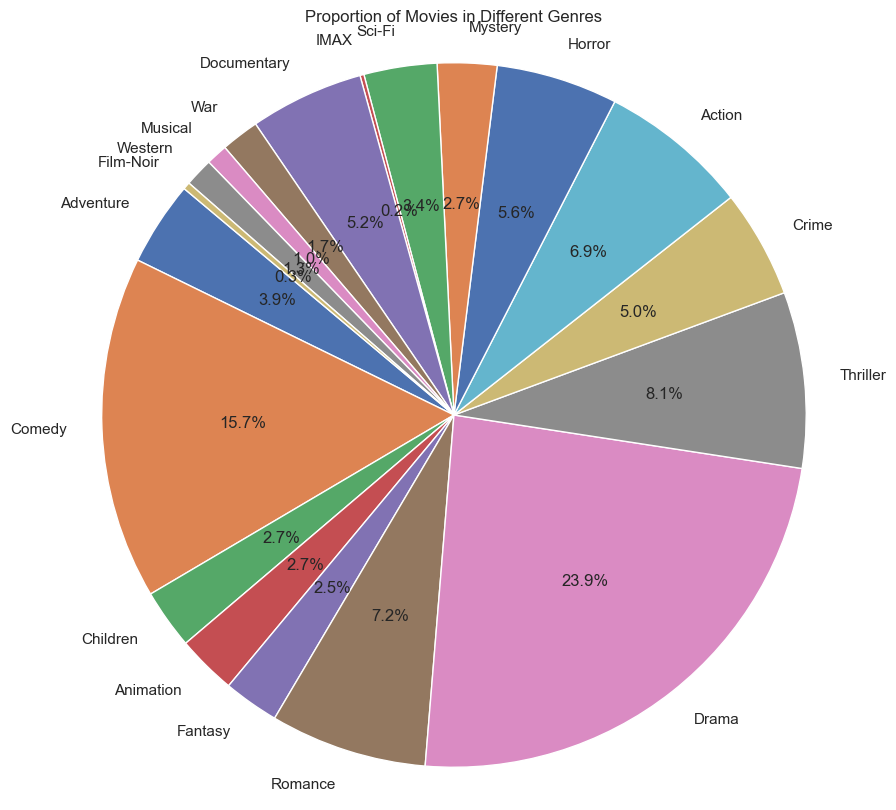

In [8]:
total_movies = sum(genres.values())

# Calculate the proportion of each genre
genre_proportions = [value / total_movies for value in genres.values()]

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(genre_proportions, labels=genres.keys(), startangle=140, autopct='%1.1f%%')
plt.title('Proportion of Movies in Different Genres')
plt.axis('equal')
plt.show()

In [9]:
# Checking the size of the datasets
print(f"Ratings dataset: {ratings.shape}")
print(f"Movies dataset: {movies.shape}")

# Number of unique users and movies
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

# Basic statistics about the dataset
print(f"Number of ratings: {n_ratings}")
print(f"Number of movies: {n_movies}")
print(f"Number of users: {n_users}")
print(f"Average ratings per user: {n_ratings / n_users:.2f}")
print(f"Average ratings per movie: {n_ratings / n_movies:.2f}")


Ratings dataset: (13296, 4)
Movies dataset: (62423, 3)
Number of ratings: 13296
Number of movies: 3809
Number of users: 100
Average ratings per user: 132.96
Average ratings per movie: 3.49


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,13296.000000,13296.000000,13296.000000,1.329600e+04
mean,47.875150,18684.278279,3.568028,1.205507e+09
std,30.070964,34499.163526,1.019764,2.247005e+08
min,1.000000,1.000000,0.500000,8.287085e+08
25%,19.000000,1097.000000,3.000000,9.834400e+08
50%,49.000000,2692.000000,4.000000,1.186857e+09
75%,75.000000,7451.000000,4.000000,1.439473e+09
max,100.000000,203519.000000,5.000000,1.574195e+09


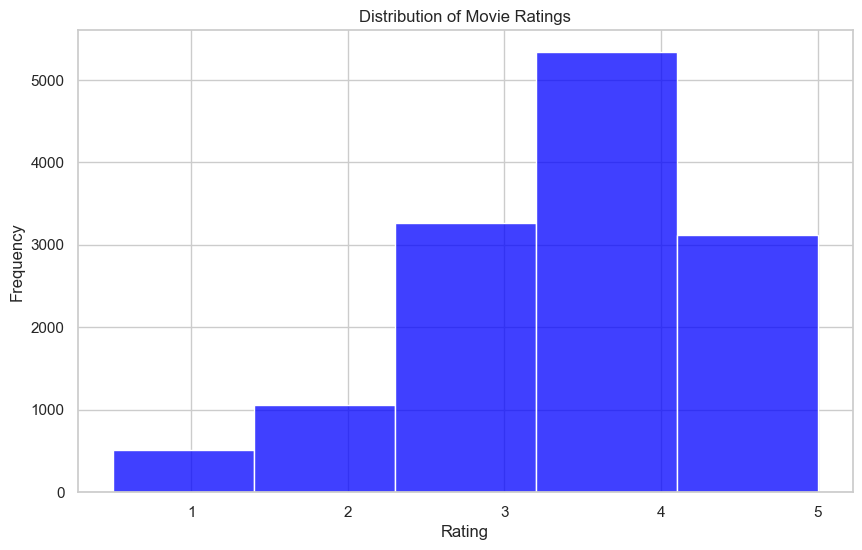

In [11]:
# Visualizing the distribution of movie ratings
plt.figure(figsize=(10,6))
sns.histplot(ratings['rating'], bins=5, kde=False, color='blue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [12]:
ratings.sort_values(by='rating', ascending=False)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
5227,37,2858,5.0,1456484551
5203,36,1376,5.0,867749420
5208,36,5060,5.0,867952278
5211,37,50,5.0,1456485085
...,...,...,...,...
251,2,35836,0.5,1141417449
12824,95,74754,0.5,1511480583
4556,30,6711,0.5,1488511452
2525,13,1562,0.5,1237970560


In [13]:
# Creating a matrix to represent the user-movie interactions
def create_matrix(df):
    N = len(df['userId'].unique())  # Number of users
    M = len(df['movieId'].unique())  # Number of movies

    user_mapper = dict(zip(np.unique(df['userId']), list(range(N))))
    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df['userId'])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df['movieId'])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    # Building the sparse matrix (movie-user interaction)
    X = csr_matrix((df['rating'], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

print(f"Sparse matrix shape: {X.shape}")


Sparse matrix shape: (3809, 100)


In [16]:
# KNN for finding similar movies
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    neighbor_ids = []
    movie_ind = movie_mapper[movie_id]  # Find the index of the movie
    movie_vec = X[movie_ind]  # Get the movie vector
    
    k += 1  # Increase k by 1 to include the movie itself in neighbors
    knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric)
    knn.fit(X)
    
    movie_vec = movie_vec.reshape(1, -1)
    distances, indices = knn.kneighbors(movie_vec)  # Always returns two arrays: distances and indices
    
    # Skip the first neighbor, as it's the movie itself
    for i in range(1, k):
        n = indices[0][i]  # Get the index of the neighbor movie
        neighbor_ids.append(movie_inv_mapper[n])
    
    return neighbor_ids






# Finding movies similar to a specific movie
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 74  # Example movie ID (can be changed to another movie)

# Find and print similar movies
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]
result = movies[movies['title'] == movie_title]
genres = result['genres'].values[0]


    


In [17]:
from prettytable import PrettyTable
print(f"Since you watched {movie_title}||{genres}:")
table = PrettyTable()
table.field_names = ["Movie title", "genres"]
for i in similar_ids:
    row = []
    row.append(movie_titles[i])
    result1 = movies[movies['title'] == movie_titles[i]]
    gen = result1['genres'].values[0]
    row.append(gen)
    table.add_row(row)
print(table)
    


Since you watched Bed of Roses (1996)||Drama|Romance:
+----------------------------------+--------------------------------+
|           Movie title            |             genres             |
+----------------------------------+--------------------------------+
|     Ladybird Ladybird (1994)     |             Drama              |
|  Something to Talk About (1995)  |      Comedy|Drama|Romance      |
|         Showgirls (1995)         |             Drama              |
|        Phenomenon (1996)         |         Drama|Romance          |
|         Threesome (1994)         |         Comedy|Romance         |
|    Courage Under Fire (1996)     |     Action|Crime|Drama|War     |
|        Speechless (1994)         |         Comedy|Romance         |
| Secret of Roan Inish, The (1994) | Children|Drama|Fantasy|Mystery |
| When a Man Loves a Woman (1994)  |         Drama|Romance          |
|          Sabrina (1995)          |         Comedy|Romance         |
+----------------------------------+